# OilyGiant Mining Company - New Well Prediction

OilyGiant is a mining company that is looking to dig a new well. The company has collected data on the oil quality and volume of reserves in different regions. Based on this information, we are tasked with building a model for predicting the volume of reserves in new wells, determining which oil wells have the highest estimated values, and identifying the region with the higest potential for profit.

**Table of Contents:**
* [1 Import Libraries and Preprocess the Data](#1)
    * [1.1 Import Libraries](#1.1)
    * [1.2 Import Data](#1.2)
    
    * [1.3 Concatenate Region Data for Preprocessing](#1.3)
    * [1.4 Check for Missing Values](#1.4)
    * [1.5 Check for Duplicates](#1.5)
    * [1.6 Examine Sample Data](#1.6)
    * [1.7 Check Datatype Informatin](#1.7)
    * [1.8 Data Preprocessing Conclusion](#1.8)
* [2 Train and Test Model for Each Region](#2)
    * [2.1 Separate Data by Region](#2.1)
    * [2.2 Split Data into Training and Validation Sets](#2.2)
    * [2.3 Train the Models and Make Predictions](#2.3)
    * [2.4 Calculate RMSEs and Average Predicted Reserve Volumes](#2.4)
    * [2.5 Check for Correlations](#2.5)
    * [2.6 Analyze the Results](#2.6)
* [3 Prepare for Profit Calculation](#3)
    * [3.1 Specify Principal Values](#3.1)
    * [3.2 Find Minimum Acceptable Well Reserve Volume](#3.2)
* [4 Profit Calculation](#4)
    * [4.1 Select Wells with Highest Predicted Product Values](#4.1)
    * [4.2 Examine Distributions of Product](#4.2)
    * [4.3 Estimated Profit for Each Region (Top 200 Wells)](#4.3)
    * [4.4 Profit Calculation Conclusion](#4.4)
* [5 Risk and Profit Calculations for Each Region](#5)
    * [5.1 Find Distribution of Profit via Bootstrapping](#5.1)
    * [5.2 Profit Calculations](#5.2)
* [6 Conclusion](#6)

## Import Libraries and Preprocess the Data<a class="anchor" id='1'></a>

### Import Libraries<a class="anchor" id='1.1'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split as tts
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from numpy.random import RandomState

### Import Data<a class="anchor" id='1.2'></a>

In [2]:
try:
    geo1 = pd.read_csv('/datasets/geo_data_0.csv')
    geo2 = pd.read_csv('/datasets/geo_data_1.csv')
    geo3 = pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    geo2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    geo3 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

### Concatenate Region Data for Preprocessing<a class="anchor" id='1.3'></a>

In [3]:
#Add column to identify region for concatenated DataFrame.
geo1['region'] = 1
geo2['region'] = 2
geo3['region'] = 3

#Concatenate DataFrames
regions_df = pd.concat([geo1, geo2, geo3]).reset_index(drop=True)

### Check for Missing Values<a class="anchor" id='1.4'></a>

In [4]:
print("Missing values in DataFrame by column:")
print(regions_df.isnull().sum())

Missing values in DataFrame by column:
id         0
f0         0
f1         0
f2         0
product    0
region     0
dtype: int64


### Check for Duplicates<a class="anchor" id='1.5'></a>

In [5]:
#Check for duplicates in subset in case same values were input for multiple regions.
print("Total duplicated rows: {}".format(regions_df.duplicated(subset=['f0', 'f1', 'f2', 'product']).sum()))

Total duplicated rows: 0


### Examine Sample Data<a class="anchor" id='1.6'></a>

In [6]:
display(regions_df.head())

,id,f0,f1,f2,product,region
0,txEyH,0.705745,-0.497823,1.221170,105.280062,1
1,2acmU,1.334711,-0.340164,4.365080,73.037750,1
2,409Wp,1.022732,0.151990,1.419926,85.265647,1
3,iJLyR,-0.032172,0.139033,2.978566,168.620776,1
4,Xdl7t,1.988431,0.155413,4.751769,154.036647,1


In [7]:
## Find range of values for each column
def minmax(column):
    min_val = min(regions_df[column])
    max_val = max(regions_df[column])
    return(min_val, max_val)

#Save ranges to DataFrame for visualization.
ranges = pd.DataFrame([minmax(column) for column in regions_df.columns[1:4]], index=['f0', 'f1', 'f2'], columns=['min', 'max'])

print('Minimum and maximum values for feature columns:')
display(ranges)

Minimum and maximum values for feature columns:


,min,max
f0,-31.609576,29.421755
f1,-26.358598,18.734063
f2,-12.088328,16.739402


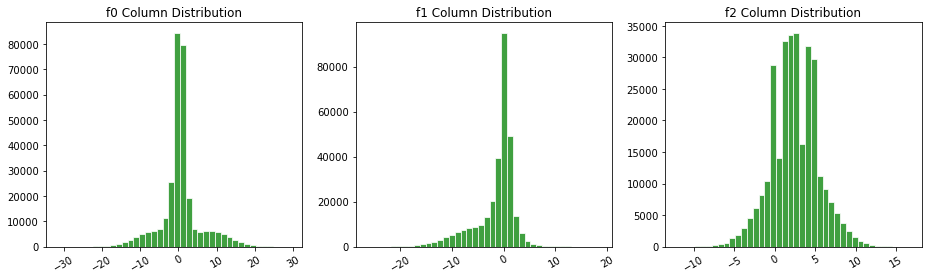

In [8]:
#Select columns to plot histograms of.
hist_columns = ['f0', 'f1', 'f2']

#Plot histograms to visualize distributions.
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(13, 4))

for col, ax in zip(hist_columns, axs.flatten()):
    ax.hist(regions_df[col], bins=40, color='green', density=False, alpha=.75, edgecolor='w')
    ax.set_title(col + ' Column Distribution', fontsize=12)
    ax.tick_params(axis='x', labelrotation=30)

plt.tight_layout()
plt.show()

1.6 Notes: From our sample, we can see that our DataFrame has 6 columns, 5 of which were included in the imported datasets. The column information may be broken down as follows:

* id: Unique oil well identifier.


* f0, f1, f2: Key feature points for wells (specific meaning unknown). These will be used as features for our models.


* product: Volume of reserves in the oil wells (thousand barrels).


* region: Added to track which region a well belongs to in unified dataset.

To get a feel for the values in the 'f' columns, we obtained the minimum and maximum value in each column. The values appear to be centered around 0. To visualize the distributions, we created histograms for the values from each column. As it turns out, the values in each column appear to be approximately normally distributed, albeit around slightly different means. 

The purpose of examining the features' value ranges and distributions was to understand whether we should standardize the data. Doing so would be appropriate if the values in the different feature columns were scaled differently, which would mean that features with greater values would be seen as more valuable by regression models. Since the values for these features *appear* to share a common scale - that is, the minimum and maximum values for each feature do not appear to be wildly larger or smaller than one another - we do not believe that we should scale the data ourselves. We emphasize the term 'appear', as we believe that without an understanding of what the features represent, we are not able to accurately determine whether the values are scaled. 

### Check Datatype Information<a class="anchor" id='1.7'></a>

In [9]:
regions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       300000 non-null  object 
 1   f0       300000 non-null  float64
 2   f1       300000 non-null  float64
 3   f2       300000 non-null  float64
 4   product  300000 non-null  float64
 5   region   300000 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 13.7+ MB


1.7 Notes: Given this info, we can see that all columns are of the appropriate datatype. As such, we do not need to change the datatype of any column.  

### Data Preprocessing Conclusion<a class="anchor" id='1.8'></a>

In this section, we preprocessed the data that we will be using for our analyses. To do so, we imported the datasets for the 3 different regions and combined all the data into one DataFrame using a specific column value to differentiate data from each region. We found that there are no missing values in the DataFrame, no duplicates, and the values for the 'f' columns are approximately normally distributed. Given the closeness of the minimum and maximum values in each 'f' column, as well as the lack of information concerning what the values represent, we have chosen not to standardize the data in those columns.

In the following section, we will train and test a linear regression model for each region with the purpose of finding the average volume of predicted reserves in each region, as well as each model's RMSE.

## Train and Test Model for Each Region<a class="anchor" id='2'></a>

### Separate Data by Reion<a class="anchor" id='2.1'></a>

In [10]:
#Prior to training and testing models, split data into sets by region.
region_1 = regions_df.loc[regions_df['region'] == 1]
region_2 = regions_df.loc[regions_df['region'] == 2]
region_3 = regions_df.loc[regions_df['region'] == 3]

#Drop identifier column and reset indexes.
region_1 = region_1.drop(columns='region').reset_index(drop=True)
region_2 = region_2.drop(columns='region').reset_index(drop=True)
region_3 = region_3.drop(columns='region').reset_index(drop=True)

### Split the Data into Training and Validation Sets<a class="anchor" id='2.2'></a>

In [11]:
#Create function to split the data into training and validation sets using a ratio of 3:1.
def split(df):
    features = df.drop(columns=['id', 'product'])
    target = df['product']
    return tts(features, target, test_size=0.25, random_state=12345)

#Region 1 Data:
r1_Xtrain, r1_Xvalid, r1_ytrain, r1_yvalid = split(region_1)

#Region 2 Data:
r2_Xtrain, r2_Xvalid, r2_ytrain, r2_yvalid = split(region_2)

#Region 3 Data:
r3_Xtrain, r3_Xvalid, r3_ytrain, r3_yvalid = split(region_3)

### Train the Model and Make Predictions<a class="anchor" id='2.3'></a>

In [12]:
#Create function to train model and return predictions
def model_pred(Xtrain, Xvalid, ytrain, yvalid):
    model = LinearRegression().fit(Xtrain, ytrain)
    return model.predict(Xvalid), model.score(Xvalid, yvalid)

#Region 1 Predictions:
r1_prediction, r1_score = model_pred(r1_Xtrain, r1_Xvalid, r1_ytrain, r1_yvalid)

#Region 2 Predictions:
r2_prediction, r2_score = model_pred(r2_Xtrain, r2_Xvalid, r2_ytrain, r2_yvalid)

#Region 3 Predictions:
r3_prediction, r3_score = model_pred(r3_Xtrain, r3_Xvalid, r3_ytrain, r3_yvalid)

### Calculate RMSEs and Average Predicted Reserve Volumes <a class="anchor" id='2.4'></a>

In [13]:
#Create function to carry out calculations and neatly present values.
def rmse_vol(region, yactual, ypredict, score):
    rmse = mean_squared_error(yactual, ypredict) ** .5
    average_volume = ypredict.mean()
    df_values = pd.DataFrame([[rmse.round(2), score.round(4), average_volume.round(2)]], columns=['RMSE', 'R^2 Score', 'Avg Vol.'])
    df_values.index = [region]
    return df_values

#Display values for each region
model_scores = pd.concat([rmse_vol('Region 1', r1_yvalid, r1_prediction, r1_score)] + \
                  [rmse_vol('Region 2', r2_yvalid, r2_prediction, r2_score)] + \
                  [rmse_vol('Region 3', r3_yvalid, r3_prediction, r3_score)])

display(model_scores)

,RMSE,R^2 Score,Avg Vol.
Region 1,37.58,0.2799,92.59
Region 2,0.89,0.9996,68.73
Region 3,40.03,0.2052,94.97


### Check for Correlations<a class="anchor" id='2.5'></a>

In [14]:
#Create function to return correlation of product with 'f' columns for each region.
def corr_df(region_name, region_var):
    corr = region_var[['f0', 'f1', 'f2']].corrwith(region_var['product']).to_list()
    corr = [round(x, 4) for x in corr]
    corr_df = pd.DataFrame([corr], columns=['f0', 'f1', 'f2'])
    corr_df.index = [region_name]
    return corr_df
    
#Print correlation values between features and target.
print('Correlations between features and target per region.')
display(pd.concat([corr_df('Region 1 Product', region_1)] + \
                  [corr_df('Region 2 Product', region_2)] + \
                  [corr_df('Region 3 Product', region_3)]))

Correlations between features and target per region.


,f0,f1,f2
Region 1 Product,0.1435,-0.1924,0.4837
Region 2 Product,-0.0305,-0.0102,0.9994
Region 3 Product,-0.0020,-0.0010,0.4459


### Analyze the Results<a class="anchor" id='2.6'></a>

In order to judge the accuracy of our models, we calculated the RMSE and R^2 scores for each model using the relevant validation datasets. We also calculated the average predicted volume of the reserves (in thousand barrels) in each region. As a quick note, the scores we calculated convey the following:

   * RMSE (Root Mean Squared Error): This metric represents the standard deviation of residulals, which are the differences between predicted values and actual values. The lower the RMSE score is for a model, the less spread out the actual values are from the predicted values.
   
   
   * R^2: This metric represents the proportion of the variance for a dependent variable (i.e., the target) that is explained by a set of indepenent variables in a regression model. In other words, the R^2 values tells us how much of the variance of a dependent variable can be gotten rid of by summing up the squared distances of independent variables from a regression line, rather than from the mean. The best R^2 score is 1, which means that all movements of a dependent variable are explained by movements of the independant variables.  
   
Based on our calculations, we can see that the average predicted volumes in the reserves are highest for Region 1 and Region 3; these average predicted volumes differ by less than 3 thousand barrels. While Region 3's average predicted reserve volume is around 24-26 thousand barrels less than the average predicted volumes of reserves in Region 1 and Region 3, the R^2 score of the model for Region 2 is much higher than that of the others', and its RMSE value is far lower. This means that the predicted product values are much closer to the actual product values for Region 2 than the other regions. And, given Region 2's model's R^2 score of approximately .9994, the model explains over 99% of the variability of the target's values around its mean.  

Given the high R^2 score for Region 2's model, we decided to examine the correlation coefficient for each region's 'f' values and the corresponding product values. Whereas Region 1 and Region 3's product values have a moderate positive correlation with their respective f2 values (around .50) Region 2's product values are very strongly correlated with its f2 values (greater than .99). 

Given this data, we can conclude that model predictions for well reserves in Region 2 are, on average, closer to the actual sizes of the wells than model predictions for reserves in Regions 1 and 3. In the next sections, we will calculate the potential risk and profit for digging new wells in each region.

## Prepare for Profit Calculation<a class="anchor" id='3'></a>

### Specify Principal Values<a class="anchor" id='3.1'></a>

In [15]:
#Number of wells to be developed.
DEV_WELLS = 200

#Number of wells to sample in bootstrapping.
N_BOOT = 500

#Revenue (in USD) per one unit of product.
PROD_REV = 4500

#Total well development budget.
BUDGET = 100000000

#Budget per well.
BUDGET_PER_WELL = BUDGET / DEV_WELLS

### Find Minimum Acceptable Well Reserve Volume<a class="anchor" id='3.2'></a>

In [16]:
#Calculate minimum volume of reserves sufficient for developing a new well without losses.
print(f"Minimum volume of reserves to avoid loss: {round((BUDGET_PER_WELL/PROD_REV), 2)}")

#Add column to model_scores for difference between each regions average volume and minimum required volume.
model_scores['Vol. Diff.'] = model_scores['Avg Vol.'] - round((BUDGET_PER_WELL/PROD_REV), 2)

display(model_scores)

Minimum volume of reserves to avoid loss: 111.11


,RMSE,R^2 Score,Avg Vol.,Vol. Diff.
Region 1,37.58,0.2799,92.59,-18.52
Region 2,0.89,0.9996,68.73,-42.38
Region 3,40.03,0.2052,94.97,-16.14


3.2 Notes: In this subsection, we used key values specified by OilyGiant to calculate the available budget for developing each well. Using this budget, we calculated the minimum volume of reserves required to develop a new well without losses (i.e., approximately 111.11). It should be noted that these calculations were based on the revenue generated by each unit of product; as such, we must assume that all operating costs, expenses, and obligations are included in the budget to conclude that the calculated value does not result in losses. 

To visualize how the average predicted well volume in each region compares to the minimum required volume to ensure no losses, we added a new column to our model_scores table. The values in the 'Vol. Diff' column were obtained by subtracting the values in the 'Avg Vol.' column from the minimum required reserve volumne. As can be seen, the average predicted well volume in each region is below the minimum required volume; as such, in order to find out which region would be best to develop in, we will need to calculate the potential profit for each region based on their highest-predicted-volume wells and obtain a confidence interval for the values.

## Profit Calculation<a class="anchor" id='4'></a>

### Select Wells With Highest Predicted Product Values<a class="anchor" id='4.1'></a>

In [17]:
#Create function to select best 200 wells from each region based on predictions.
def best_200(region_target, prediction):
    predictions_sorted = pd.Series(prediction, index=region_target.index).sort_values(ascending=False)
    top_target = region_target.loc[predictions_sorted.index][:DEV_WELLS]
    return top_target

#Obtain top 200 wells per region and it's actual product value based on highest predicted value.
region_1_top = best_200(r1_yvalid, r1_prediction)
region_2_top = best_200(r2_yvalid, r2_prediction)
region_3_top = best_200(r3_yvalid, r3_prediction)

### Examine Distributions of Product<a class="anchor" id='4.2'></a>

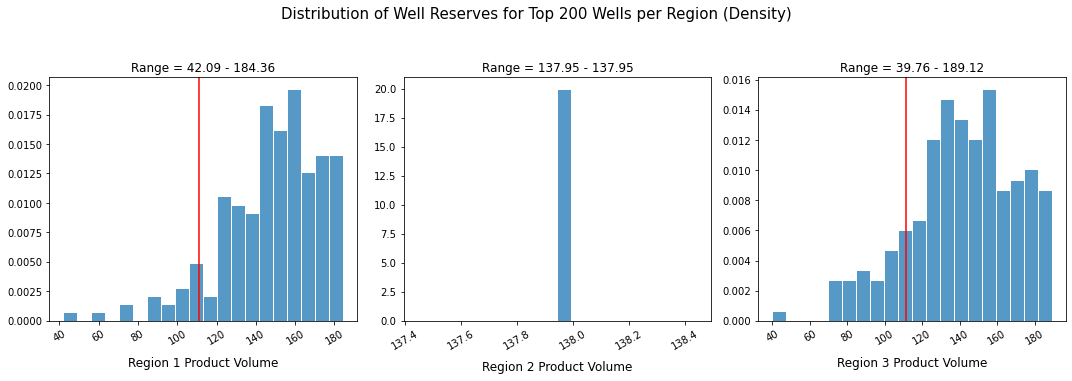

In [18]:
#Select columns to plot histograms of.
hist_data = [region_1_top, region_2_top, region_3_top]
hist_name = ['Region 1', 'Region 2', 'Region 3']

#Create plot figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Well Reserves for Top 200 Wells per Region (Density)', fontsize=15, y=1.05)

#For loop to create density histograms.
for data, name, num in zip(hist_data, hist_name, range(0,3)):
    sns.histplot(data, ax=axes[num], bins=20, stat='density', edgecolor='w')
    axes[num].set_title(f'Range = {round(min(data),2)} - {round(max(data),2)}')
    axes[num].tick_params(axis='x', labelrotation=30)
    axes[num].set_xlabel(name + ' Product Volume', fontsize=12, labelpad = 10)
    axes[num].set_ylabel('')
    if min(data) < (BUDGET_PER_WELL/PROD_REV):
        axes[num].axvline(x=(BUDGET_PER_WELL/PROD_REV), color='red')
    
plt.tight_layout()
plt.show()

4.2 Notes: In tis subsection, we created density histograms for the distribution of values for the top 200 wells' products for each region; the red line represents the minimum required threshold for a well to be profitable. As we can see from our distributions, for Region 1 and Region 3, most of the well volumes from the top 200 wells (based on our models' predictions) are above the minimum required threshold for profit. Interestingly, all wells are above the minimum threshold volume in Region 2 - in fact, all of the top 200 wells appear to have the same volume (as can be seen from the range calculation in the subplot's title). This is an unexpected result, as it would be highly unlikely for all of the top 200 wells to have the same values. To get a sense for the overall distributions in each region, and attempt to understand why the top 200 wells appear to share the same product value in Region 2, we will plot density histograms for all product distributions in each region.

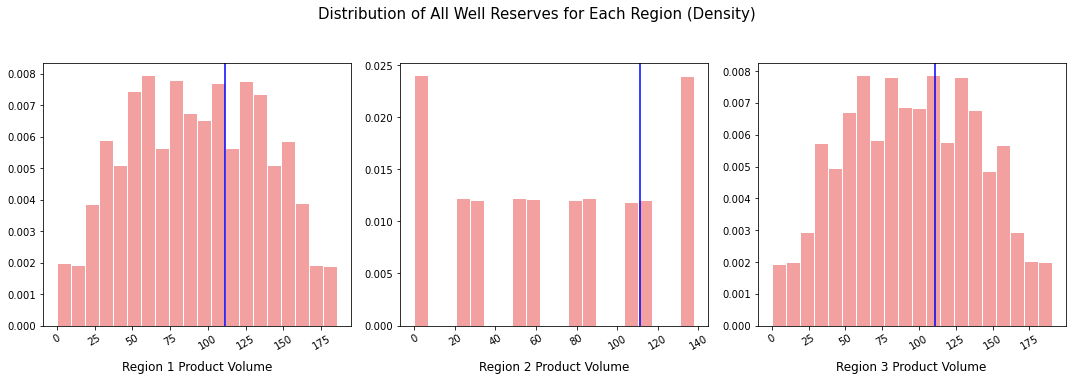

In [19]:
#Select columns to plot histograms of.
hist_data2 = [region_1, region_2, region_3]

#Create plot figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of All Well Reserves for Each Region (Density)', fontsize=15, y=1.05)

#For loop to create density histograms.
for data, name, num in zip(hist_data2, hist_name, range(0,3)):
    sns.histplot(data['product'], ax=axes[num], bins=20, stat='density', edgecolor='w', color='lightcoral')
    axes[num].tick_params(axis='x', labelrotation=30)
    axes[num].set_xlabel(name + ' Product Volume', fontsize=12, labelpad = 10)
    axes[num].set_ylabel('')
    if min(data['product']) < (BUDGET_PER_WELL/PROD_REV):
        axes[num].axvline(x=(BUDGET_PER_WELL/PROD_REV), color='blue')
    
plt.tight_layout()
plt.show()

4.2 Notes Continued: Whereas we have seemingly normal distributions for product values for Region 1 and Region 3, the product values for wells in Region 2 appear to be distributed around key values. Unfortunately, without more information we are not able to determine exactly why the values for Region 2 are distributed differently than for those of the other two regions. That being said, we believe a likely explanation is that product values for wells in Region 2 were rounded or grouped, rather than input exactly - this appears to be supported by the seemingly even empty intervals between bars in the above histogram for Region 2.

Nonetheless, it appears that all of the top 200 wells in Region 2 contain more reserves than the minimum required value; assuming that the values are rounded or grouped and are not exact, so long as the actual value of the wells is not approximately 18% less than the listed value, then they are still above the negative threshold. As for Region 1 and Region 3, a portion of wells listed in the top 200 have reserves below the minimum threshold; however, the upper range of well reserve values is larger for both regions than for Region 2. 

In the following subsection, we will calculate the profit that may have been generated for each of the top 200 wells in each region. It's important to note, however, that we do not know the true cost of developing each of the wells; as such, our calculations will assume that the development of the wells, and all related expenses, equaled the full 100 Million (USD) budget for each region.

### Estimated Profit for Each Region (Top 200 Wells)<a class="anchor" id='4.3'></a>

In [20]:
#Create a function to calculate the potential profit from the top 200 wells by region.
def top_profit(region):
    profit = (((region.sum() * PROD_REV) - BUDGET) / 1000000).round(2)
    total_vol = (region.sum() / 1000).round(2)
    return profit, total_vol

display(pd.DataFrame([top_profit(region_1_top), top_profit(region_2_top), top_profit(region_3_top)], \
                   columns=['Profit (USD Million)', 'Barrels (Million)'], index=hist_name))

,Profit (USD Million),Barrels (Million)
Region 1,33.21,29.60
Region 2,24.15,27.59
Region 3,27.10,28.25


### Profit Calculation Conclusion<a class="anchor" id='4.4'></a>

In this section, we calculated the profit gained from developing the top 200 wells in each region, though with one caveat. As mentioned, we do not have any data relating to the actual expenses incurred for developing the wells listed in this dataset. As such, we had to make one key assumption regarding the total expenditures made by OilyGiant in developing the wells - that is, we assumed that the total budget for developing 200 wells in each region (100 USD Million) equaled the total expendatures incurred by the company for developing 200 wells in each region. Importantly, we did not assume that this budget covered developing 200 wells in each region combined, but rather that developing 200 wells in each specific region cost 100 USD Million, for a total cost of 300 USD Million. Depending on whether or not these expenditures included OilyGiant's obligations to the state and creditors, our calculations may either be regarded as representing operating profit for each region or net profit (the latter being the value after all costs and relevant obligations have been taken into account). 

Based on our calculations, developing 200 wells in Region 1 appears to have generated the most profit, followed by Region 3. While the top 200 wells in both regions had wells with reserves under the minimum threshold, unlike with the top 200 wells in Region 2, the wells with product reserves on the higher end in Region 1 and 3 offset the losses from developing the wells with product reserves under the minimum threshold. If we had to chose a new region in which to develop wells purely based on these findings, we would suggest developing wells in Region 1.

In the following section, we will calculate the risk and profit for each region. In doing so, we will use the bootstrapping technique with 1000 samples and 500 datapoints for each region, and will use the top 200 points from each sample to calculate the profit.

## Risk and Profit Calculations for Each Region<a class="anchor" id='5'></a>

### Find Distribution of Profit via Bootstrapping<a class="anchor" id='5.1'></a>

In [21]:
#Create random number generator using RandomState.
state = RandomState(12345)

#Create function to obtain profit values via bootstrapping from 1000 samples.
def bootstrap_it(region_yvalid, prediction):
    values = []
    probs = pd.Series(prediction, index=region_yvalid.index)
    for i in range(1000):
        target_subsample = region_yvalid.sample(n=N_BOOT, replace=True, random_state=state)
        probs_subsample = probs[target_subsample.index]      
        best_200_wells = best_200(target_subsample, probs_subsample)
        values.append(top_profit(best_200_wells)[0])
    values_series = pd.Series(values)
    return values_series

r1_bootstrap_profit = bootstrap_it(r1_yvalid, r1_prediction)
r2_bootstrap_profit = bootstrap_it(r2_yvalid, r2_prediction)
r3_bootstrap_profit = bootstrap_it(r3_yvalid, r3_prediction)

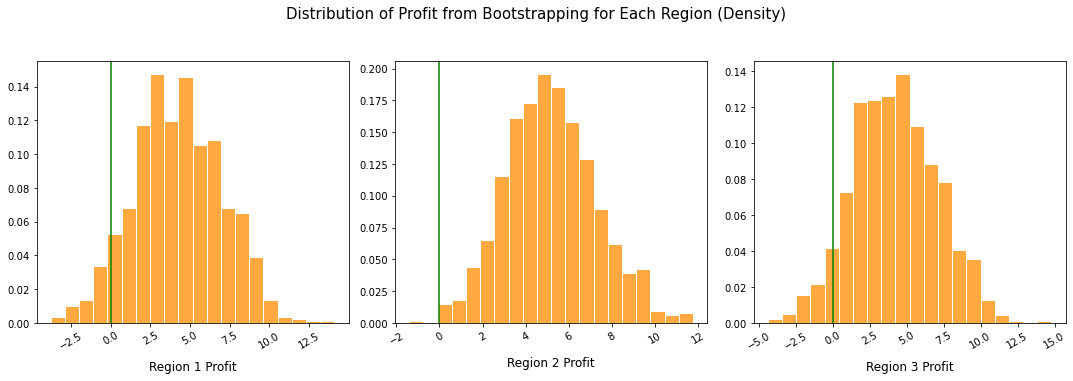

In [22]:
#Select columns to plot histograms of.
hist_data3 = [r1_bootstrap_profit, r2_bootstrap_profit, r3_bootstrap_profit]

#Create plot figure.
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=False)
fig.suptitle('Distribution of Profit from Bootstrapping for Each Region (Density)', fontsize=15, y=1.05)

#For loop to create density histograms.
for data, name, num in zip(hist_data3, hist_name, range(0,3)):
    sns.histplot(data, ax=axes[num], bins=20, stat='density', edgecolor='w', color='darkorange')
    axes[num].tick_params(axis='x', labelrotation=30)
    axes[num].set_xlabel(name + ' Profit', fontsize=12, labelpad = 10)
    axes[num].set_ylabel('')
    if min(data) < 0:
        axes[num].axvline(x=0, color='green')
    
plt.tight_layout()
plt.show()

5.1 Notes: In this subsection we used bootstrapping to find the profit distribution for wells in each region; more specifically, we took 1000 random samples of 500 wells from each region and calculated the profit from the top 200 wells in each sample. We then plotted density histograms to visualize the distribution of profit for each region. As we can see from the histograms, there appears to be a normal distribution of profit for each region. Based on appearances, Region 2 seems to have the highest average profit (this will be tested in the next subsection). Additionally, there appears to be a far lower risk of loss in Region 2 than the other regions (that is, far fewer samples return a profit value of less than 0). Whereas in the previous section we found that the profit from the top 200 wells is greatest for Region 1, when we use the bootstrapping technique to randomly sample 500 wells in each region and calculate the profit from the top 200 wells in each sample, Region 2 appears to generate the greatest average profit.

In the next subsection, we will calculate the average profit from the top 200 wells in each region based on our bootstrapping results, as well as the risk of loss and 95% confidence interval. 

### Profit Calculations<a class="anchor" id='5.2'></a>

In [23]:
#Create function to calculate key values. 
#Since we want 95% confidence interval, find values between 2.5% and 97.5% using the quantile method.
def key_values(bootstrapped):
    mean = bootstrapped.mean().round(2)
    risk = (len(bootstrapped[bootstrapped < 0]) / len(bootstrapped)) * 100
    lower = bootstrapped.quantile(.025).round(2)
    upper = bootstrapped.quantile(.975).round(2)
    return mean, risk, (lower, upper)

In [24]:
#Display values for each region.
display(pd.DataFrame([key_values(r1_bootstrap_profit), \
                      key_values(r2_bootstrap_profit), \
                      key_values(r3_bootstrap_profit)], \
                      columns=['Mean (USD Mill)', 'Risk (%)', 'Conf. Interval'], index=hist_name))

AttributeError: 'float' object has no attribute 'round'

5.2 Notes: As we can see, our calculations support our conclusions based on the histograms in subsection 5.1. The average profit is highest for Region 2 (by approximately 1 Million dollars). Furthermore, whereas there is an approximately 6% risk of losses for developing wells in Region 1 and Region 3, this risk is only .2% in Region 2. Finally, the confidence interval for the average profit for Region 2 only contains positive values, whereas the the lower bounds of the confidence intervals for Region 1 and Region 3 are negative. 

## Conclusion<a class="anchor" id='6'></a>

The goal of this project was to build a model for predicting the volume of oil well reserves in various regions and, on the basis of the results, determine which region offers the highest potential for profit. In carrying out this task, we trained linear regression models on 75 percent of the data for each region and validated the results on the final 25 percent. We then took the top 200 wells for each region, according to the algorithms' predictions, and calculated the profit generated from each. Based on these calculations, Region 1 appeared to be the most lucrative region, as the top 200 wells generated the greatest profit. 

To verify these results, we used the bootstrapping technique. In doing so, we took 1000 samples of 500 wells from each region, then calculated the profit from the top 200 wells from each region (again, based on the predicted values). We then calculated the mean profit, risk percentage, and confidence interval for the profit from each region. Interestingly, when using the bootstrapping technique we found that Region 2 generates the highest average profit, as opposed to Region 1. We believe that the reson behind this finding lies in the accuracy of our linear regression algorithms. Recall that we obtained the following scores for the algorithms:

* Region 1: RMSE - 37.58 | R^2 - .2799


* Region 2: RMSE - 00.89 | R^2 - .9996


* Region 3: RMSE - 40.03 | R^2 - .2052

As can be seen, there is a far greater standard deviation for residuals for Region 1 and Region 3 models than the Region 2 model. Additionally, the R^2 score for the Region 2 model is better, by a large margin, than the scores for the other models; given the R^2 score for Region 2's model, we can conclude that the model is able to explain almost all the variance of the dependent variable in terms of the variances of the independent variables. We found that this is most likely due to there being a strong correlation between Region 2's product values and its 'f2' values, which we did not find with Region 1's and Region 3's values.

Given the above values, we believe that bootstrapping provides us with a more accurate view of the potential profits for opening wells in the varios regions. Prior to bootstrapping, our results depended on finding the top 200 well values for each region based on the predicted values from a validation dataset with 25,000 datapoints. Given this large sample size, the top 200 samples found for each region were very likely to have included many wells from the upper bound of wells in each region. By bootstrapping, we limited our sample size to 500 for each sample, with replacement; as such, it was less likely that the same top 200 wells from our previous analysis would be included in a sample. Overall, we believe that bootstrapping provided us with a more accurate overview of the estimated profit for developing 200 wells in each region. 

As part of this investigation, we were instructed to calculate the potential risk involved with developing 200 wells in each region based on our bootstrapping results; on the basis of these calculations, we were instructed to only consider developing wells in regions with a risk of loss lower than 2.5%. Since both Region 1 and Region 3 have an approximately 6% potential for loss, the only viable region left is Region 2.

Based on these findings alone, we would recommend that OilyGiant chose Region 2 to develop its next wells in. That being said, we believe that it's important for OilyGiant to investigate why the product values for Region 2 appear to be grouped, as opposed to data points for the other regions. We think that it would be best if this analysis were rerun on datasets for each region that have the same product formats - that it, either the values are grouped for all or not. Without understanding exactly how the product values for Region 2 were recorded, we cannot fully endorse the results of this investigation.